# Importing the Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Loading the Data

In [2]:
data = pd.read_csv('Context.csv')

In [3]:
data.head()

,Text,Context
0,The eternal mystique of Goldman Sachs,Politics
1,Either you don't care enough to actually tell ...,Love
2,I am such an IDIOT.,Heavy Emotion
3,While lifting weights on Friday and doing bent...,Health
4,Something's watching me,Animals


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31386 entries, 0 to 31385
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     31386 non-null  object
 1   Context  31386 non-null  object
dtypes: object(2)
memory usage: 490.5+ KB


In [5]:
data.Context.value_counts()

Heavy Emotion    3674
Religion         3466
Love             3229
Self             3105
Compliment       3061
Animals          2622
Health           2595
Education        2534
Joke             2476
Science          2428
Politics         2196
Name: Context, dtype: int64

In [6]:
def print_plot(index):
    example = data[data.index == index][['Text', 'Context']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Context:', example[1])

In [7]:
print_plot(10)

Yea just gotta remember XD
Context: Compliment


# Cleaning the Texts

In [8]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['Text'] = data['Text'].apply(clean_text)

In [9]:
print_plot(10)

yea gotta remember
Context: Compliment


# Finding Maximum Sequence Length

In [10]:
g=[]

In [11]:
for i in data['Text']:
    g.append(i)

In [12]:
len(g)

31386

In [13]:
len(g[10])

18

In [14]:
len(g[2458])

145

In [15]:
maxl = max([len(s) for s in g])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 4623


In [16]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 39226 unique tokens.


# Padding

In [17]:
X = tokenizer.texts_to_sequences(data['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (31386, 200)


In [18]:
Y = pd.get_dummies(data['Context']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (31386, 11)


# Train and Test Split up

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(28247, 200) (28247, 11)
(3139, 200) (3139, 11)


# Creating LSTM Model

In [20]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
398/398 [==============================] - 250s 624ms/step - loss: 1.8710 - accuracy: 0.3529 - val_loss: 1.3236 - val_accuracy: 0.5696
Epoch 2/5
398/398 [==============================] - 281s 705ms/step - loss: 1.0250 - accuracy: 0.6715 - val_loss: 1.1618 - val_accuracy: 0.6358
Epoch 3/5
398/398 [==============================] - 297s 746ms/step - loss: 0.6476 - accuracy: 0.7986 - val_loss: 1.2134 - val_accuracy: 0.6457
Epoch 4/5
398/398 [==============================] - 324s 813ms/step - loss: 0.4478 - accuracy: 0.8640 - val_loss: 1.2762 - val_accuracy: 0.6411
Epoch 5/5
398/398 [==============================] - 353s 888ms/step - loss: 0.3368 - accuracy: 0.8979 - val_loss: 1.3705 - val_accuracy: 0.6258


# Model Summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 11)                1111      
                                                                 
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________


# Evaluating the Model

In [39]:
accr = model.evaluate(X_test, Y_test)
print('Test set\n Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

99/99 [==============================] - 3s 32ms/step - loss: 1.4359 - accuracy: 0.6078 1s - loss: 1.4348  - ETA: 0s - loss: 1.4304 
Test set
 Loss: 1.436
  Accuracy: 0.608


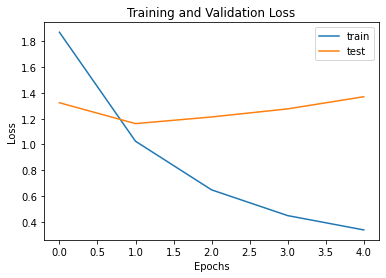

In [36]:
plt.title('Training and Validation Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

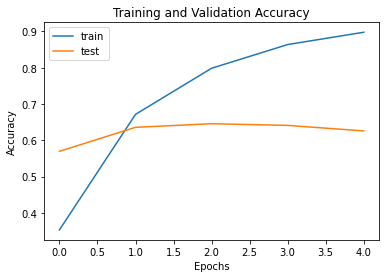

In [37]:
plt.title('Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

# Final Inference

As we know, Deep learning models need large data sets to perform efficiently (Accuracy). Even though with minimal 
datasets fine tuning can help to increase its accuracy further.

# Relevant Hyperparameters can be tuned:

a. Add more LSTM layers and increase no of epochs or batch size see the accuracy results. 

b. We can add regularizers and/or dropout to decrease the learning capacity of your model. 

c. Sometime adding more epochs also leads to overfitting the model ,due to this testing accuracy will be decreased. 
   Need to be balanced on no of epochs and batch size.

d. Adaptive Learning rate and Gradient Clipping can also be used to optimize the LSTM model.

